# Customizing X-ray System Components Classes

This guide aims to provide you with the knowledge necessary to customize classes of X-ray system components, such as sources, filters, and scintillators, with custom parameters.
You will learn how to subclass `Base_Spec_Model` for X-ray system components like sources, filters, and scintillators.

This tutorial covers:

- **Models of X-ray System Components and Classes**: A brief overview of how spectral classes reflect X-ray system components.

- **Model Examples**:
  - **Analytical Model**: Constructing a model based on mathematical expressions.
  - **Interpolation Model**: Developing a model by interpolating from a list of X-ray spectra.


## Models of X-ray System Components and Classes

**Definition:** A spectral class should encapsulate an X-ray system component with initialization of necessary parameters $ \theta_1 \in \{0, 1, 2\} $, $ \theta_2 \in [0, 2] $ (both discrete and continuous) and their respective solution sets or ranges, along with a forward function $ S(E; \theta_1, \theta_2) $ that takes energy as input and returns an energy response.

**User Preparation:** An energy response function (analytical or interpolation) with the necessary component's parameters.

**Expected Output:** A PyTorch module for a specific X-ray component, which can do auto-gradient for spectral estimation.

**Where to use?** 

    1. Calculate X-ray system response. 
    2. Spectral Estiamtion.

## Analytical Model Case Study: Creating a Filter Model with `Base_Spec_Model`

In this case study, we subclass the `Base_Spec_Model` to define a filter class. This model simulates the behavior of X-ray filters using Beer's Law, leveraging the mass attenuation coefficients from NIST to predict how different materials and thicknesses attenuate X-ray energies.

### User Preparation
#### 1. Parameters
- **$M:$ Materials**: Possible set of discrete parameter. User should provide possible filter materials as a list. Each element in the list should be an instance of class `Material` defined by a chemical formula and density. 
- **$T:$ Thickness**: Range of continuous parameter. User should provide a range specified as a tuple `(initial value, lower bound, upper bound)`.

##### Initialization: Fit parameters to `Base_Spec_Model`
Maintain a list of dictionaries, where each dictionary represents a possible combination of discrete and continuous parameters.
During estimation, xcal will solve the continuous parameters within a specific range for each possible combination.
Below is the example, assuming thickness initial and range are same for all possible material.  

```python

def __init__(self, materials, thickness):
    """
    A template filter model based on Beer's Law and NIST mass attenuation coefficients, including all necessary methods.

    Args:
        materials (list): A list of possible materials for the filter,
            where each material should be an instance containing formula and density.
        thickness (tuple): (initial value, lower bound, upper bound) for the filter thickness (mm).
            These three values cannot be all None. It will not be optimized when lower == upper.
    """
    params_list = [{'material': mat, 'thickness': thickness} for mat in materials]
    super().__init__(params_list)

```

#### 2. Response Function
The filter response model is based Beer's Law.
$$
S^{fl}(E; M, T) = e^{-\mu_M(E) \cdot T}
$$
where $\mu_M(E)$ is linear attenuation coefficiednt(LAC) of material M, which is obtained from NIST.

##### Forward Method

The `forward` method calculates the filter response for a given range of X-ray energies, utilizing the `gen_fltr_res` function. This function applies Beer's Law to determine how the selected material and its thickness attenuate the X-ray energies.

##### Read parameters.

```python
mat = self.get_params()[f"{self.prefix}_material"]
th = self.get_params()[f"{self.prefix}_thickness"]
```
##### Call filter response function
```python
gen_fltr_res(energies, mat, th)
```

In [1]:
import torch
from xcal import Material
from xcal.chem_consts import get_lin_att_c_vs_E
from xcal.models import Base_Spec_Model

def gen_fltr_res(energies, fltr_mat: Material, fltr_th: float):
    # thickness is in mm
    mu = get_lin_att_c_vs_E(fltr_mat.density, fltr_mat.formula, energies)
    mu = torch.tensor(mu, dtype=torch.float)
    att = torch.exp(-mu * fltr_th)

    return att


class Filter(Base_Spec_Model):
    def __init__(self, materials, thickness):
        """
        A template filter model based on Beer's Law and NIST mass attenuation coefficients, including all necessary methods.

        Args:
            materials (list): A list of possible materials for the filter,
                where each material should be an instance containing formula and density.
            thickness (tuple): (initial value, lower bound, upper bound) for the filter thickness (mm).
                These three values cannot be all None. It will not be optimized when lower == upper.
        """
        params_list = [{'material': mat, 'thickness': thickness} for mat in materials]
        super().__init__(params_list)

    def forward(self, energies):
        """
        Takes X-ray energies and returns the filter response.

        Args:
            energies (torch.Tensor): A tensor containing the X-ray energies of a poly-energetic source in units of keV.

        Returns:
            torch.Tensor: The filter response as a function of input energies, selected material, and its thickness.
        """
        mat = self.get_params()[f"{self.prefix}_material"]
        th = self.get_params()[f"{self.prefix}_thickness"]
        # print('ID filter th:', id(th))
        return gen_fltr_res(energies, mat, th)

{'Filter_1_material': Material(formula='Al', density=2.702),
 'Filter_1_thickness': tensor(5., grad_fn=<ClampFunctionBackward>)}


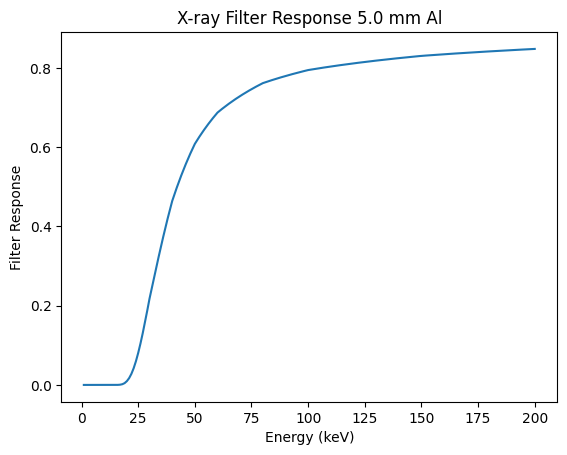

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pprint


psb_fltr_mat = [Material(formula='Al', density=2.702), Material(formula='Cu', density=8.92)]
filter_1 = Filter(materials = psb_fltr_mat, thickness=(5, 0, 10))
params = filter_1.get_params()
pprint.pprint(params)
with torch.no_grad():
    energies = np.linspace(1, 200, 200)  # X-ray energies from 1 to 200 keV
    plt.plot(energies, filter_1(energies))  # Plotting the filter response
    plt.xlabel('Energy (keV)')
    plt.ylabel('Filter Response')
    plt.title(f'X-ray Filter Response {params[f"{filter_1.prefix}_thickness"].numpy()} mm {params[f"{filter_1.prefix}_material"].formula}')
    plt.show()
    

## Interpolation Model Case Study: Creating a Source Model with `Base_Spec_Model`

In this case study, we subclass the `Base_Spec_Model` to define a reflection source class. Since sources do not have a reliable analytical formula, we try to use an interpolation model instead.

### User Preparation
#### 1. Parameters
- **$M:$ Materials**: Possible set of discrete parameter. User should provide possible anode materials as a list. Each element in the list is chemical formula in string form.
- **$T:$ Take-off Angle**: Range of continuous parameter. User should provide a range specified as a tuple `(initial value, lower bound, upper bound)`.

##### Initialization: Fit parameters to `Base_Spec_Model`
Maintain a list of dictionaries, where each dictionary represents a possible combination of discrete and continuous parameters.
During estimation, xcal will solve the continuous parameters within a specific range for each possible combination.
Also, we need to claim a spectral dictionary for interpolation.
Below is the example, 

```python

def __init__(self, materials, takeoff_angle):
    """

    Args:
        materials (list): A list of possible materials for the anode, where each material should be a string.
        takeoff_angle (tuple): (initial value, lower bound, upper bound) for the take-off angle (degree).
            These three values cannot be all None. Also, it will not be optimized when lower == upper.
    """
    params_list = [{'material': mat, 'takeoff_angle': takeoff_angle} for mat in materials]
    super().__init__(params_list)
    self.spec_dict={}

```

#### 2. Response Function
Here's the interpolation function incorporating the linear interpolation for $ \phi $:

$$
S^{sr}(E; M, \phi, D) = (1 - a) \cdot D_{M, l} + a \cdot D_{M, l+1}
$$

Where:
- $ S^{sr}(E; M, \phi, D) $ is the interpolated spectra of reflection source.
- $ E $ represents the energy.
- $ M $ represents an anode material, which is a discrete parameter.
- $ \phi $ represents the take-off angle of the anode, which is a continuous parameter to be linearly interpolated.
- $ D $ is a dictionary containing the spectra for interpolation.
- $ D_{M, l} $ and $ D_{M, l+1} $ are the spectra of the function at two adjacent points in the dictionary $ D $ corresponding to discrete parameter, anode material, $ M $.
- $ a $ is the interpolation factor, calculated based on the value of $ \phi $ relative to the values of $ \phi_l $ and $ \phi_{l+1} $. It is given by:

$$
a = \frac{{\phi - \phi_l}}{{\phi_{l+1} - \phi_l}}
$$

##### Forward Method

Besides reading parameters and calling the response function, we also need to create a dictionary for the forward function. There are multiple ways to create this dictionary, and we'll provide an example to demonstrate one possible approach.

In [3]:
from xcal.models import Interp1d

class ReflectionSource(Base_Spec_Model):
    def __init__(self, materials, takeoff_angle):
        """
    
        Args:
            materials (list): A list of possible materials for the anode, where each material should be a string.
            takeoff_angle (tuple): (initial value, lower bound, upper bound) for the take-off angle (degree).
                These three values cannot be all None. Also, it will not be optimized when lower == upper.
        """
        params_list = [{'material': mat, 'takeoff_angle': takeoff_angle} for mat in materials]
        super().__init__(params_list)
        self.spec_dict={}

    def set_spec_list(self, mat,  takeoff_angle_list, src_spec_list):

        self.src_spec_list = np.array(src_spec_list)
        self.takeoff_angle_list = np.array(takeoff_angle_list)
        self.spec_dict[mat] = Interp1d(torch.tensor(self.takeoff_angle_list, dtype=torch.float32),
                                                    torch.tensor(self.src_spec_list, dtype=torch.float32))

    def forward(self, energies):
        """
        Takes X-ray energies and returns the source spectrum.

        Args:
            energies (torch.Tensor): A tensor containing the X-ray energies of a poly-energetic source in units of keV.

        Returns:
            torch.Tensor: The source response.
        """

        mat = self.get_params()[f"{self.prefix}_material"]
        ta = self.get_params()[f"{self.prefix}_takeoff_angle"]
        src_spec = self.spec_dict[mat](ta)

        return src_spec

In [4]:
import spekpy as sp
targ_list = ['Mo','Rh', 'W']
takeoff_angle_list = [5,7,10,14,18,23,29,36,44]

spec_dict = {}
for targ in targ_list:
    src_spec_list = []
    for th in takeoff_angle_list:
        s = sp.Spek(kvp=50, th=th, dk=1, mas=1, char=True,shift=0.5, targ=targ)  # Create the spectrum model
        energies, src_spec = s.get_spectrum(edges=False)  # Get arrays of energy & fluence spectrum
        src_spec_list.append(src_spec)
    spec_dict[targ] = src_spec_list

In [5]:
source = ReflectionSource(targ_list, (15, 5, 44))
for targ in targ_list:
    source.set_spec_list(targ, takeoff_angle_list, spec_dict[targ])

{'ReflectionSource_1_material': 'Mo',
 'ReflectionSource_1_takeoff_angle': tensor(15.0000, grad_fn=<ClampFunctionBackward>)}


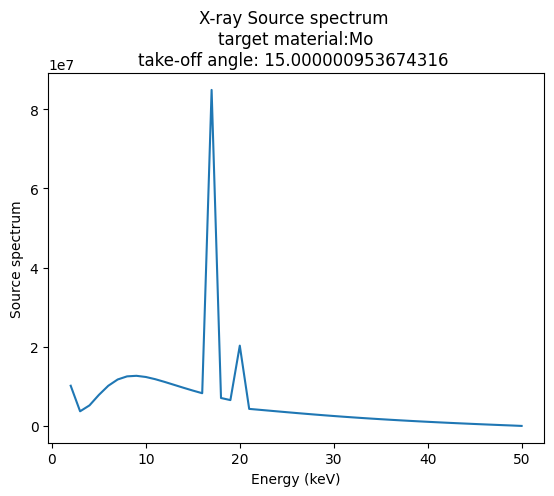

In [6]:
params = source.get_params()
pprint.pprint(params)
with torch.no_grad():
    plt.plot(energies, source(energies))  # Plotting the filter response
    plt.xlabel('Energy (keV)')
    plt.ylabel('Source spectrum')
    plt.title(f'X-ray Source spectrum \ntarget material:{params[f"{source.prefix}_material"]}\ntake-off angle: {params[f"{source.prefix}_takeoff_angle"].numpy()} ')
    plt.show()